In [1]:
import pandas as pd
import seaborn as sb
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import swifter

pd.set_option('display.max_columns', None)

In [37]:
raw_parts_alternates = pd.read_csv("../data/alternate_parts_couples.csv", low_memory=False)
raw_parts_dataset = pd.read_csv("../data/cleaned_parts_dataset.csv", low_memory=False)

In [38]:
parts_dataset = raw_parts_dataset.copy()
features_name_to_code = {x: str(index) for index, x in enumerate(parts_dataset.columns)}
features_code_to_name = {features_name_to_code[name]: name for name in features_name_to_code}
parts_dataset.columns = features_name_to_code.values()

In [39]:
numerical_features_names = [
    'AverageInventory',
    'FullCounterfeitData|CounterfeitOverallRisk',
    'FullCounterfeitData|PartNumCounterfeitReportsCount',
    'FullCounterfeitData|ManCounterfeitReportsCount',
    'FullCounterfeitData|PlCounterfeitReportsCount',
    'FullCounterfeitData|TimeSinceMarketIntroduction',
    'FullCounterfeitData|AuthorizedDistributorswithStockCount',
    'LifeCycleData|EstimatedYearsToEOL',
    'LifeCycleData|MinimumEstimatedYearsToEOL',
    'LifeCycleData|MaximumEstimatedYearsToEOL',
    'LifeCycleData|OverallRisk',
    'SummaryData|OtherSources',
    'SummaryData|AuthorizedDistributors',
    'ReachData|ReachDto|SubstanceConcentration',
    'RiskData|YearsEOL',
    'RiskData|NumberOfDistributors',
    'RiskData|NumberOfOtherSources',
    'RiskData|SEGrade',
    'PackageData|Feature>Number of Terminals:Value',
    'PackageData|Feature>Product Depth:Value',
    'PackageData|Feature>Product Diameter:Value',
    'PackageData|Feature>Product Height:Value',
    'PackageData|Feature>Product Length:Value',
    'PackageData|Feature>Product Weight:MinValue',
    'PackageData|Feature>Product Weight:MaxValue',
    'PackageData|Feature>Terminal Pitch:Value',
    'ParametricData|Features>Maximum Operating Temperature:Value',
    'ParametricData|Features>Minimum Operating Temperature:Value',
    'ParametricData|Features>Number of Terminals:Value',
    'ParametricData|Features>Product Height:Value',
    'ParametricData|Features>Product Length:Value',
    'ParametricData|Features>Tolerance:Value'
]
date_features_names = [
    'LifeCycleData|LTBDate',
    'EnvironmentalDto|ExemptionExpirationDate',
    'SummaryData|LastCheckDate',
    'SummaryData|IntroductionDate',
    'ReachData|ReachDto|SVHCListVersion',
    'ReachData|ReachDto|SVHCDateOfInclusion'
]
categorical_features_names = [
    'FullCounterfeitData|CurrentLifecycleStatus',
    'FullCounterfeitData|HistoricalShortagesInventoryReported',
    'FullCounterfeitData|IsPopularPart',
    'LifeCycleData|PartStatus',
    'LifeCycleData|PartLifecycleStage',
    'LifeCycleData|LifeCycleRiskGrade',
    'LifeCycleData|PartLifecycleCode',
    'EnvironmentalDto|RoHSStatus',
    'EnvironmentalDto|RoHSVersion',
    'EnvironmentalDto|SourceType',
    'EnvironmentalDto|Exemption',
    'EnvironmentalDto|ExemptionCodes',
    'EnvironmentalDto|RohsIdentifier',
    'EnvironmentalDto|LeadFree',
    'EnvironmentalDto|RareEarthElementInformation',
    'EnvironmentalDto|ConflictMineralStatus',
    'EnvironmentalDto|EICCMembership',
    'EnvironmentalDto|EICCTemplateVersion',
    'EnvironmentalDto|HalgonFree',
    'EnvironmentalDto|ChinaRoHS|ChinaRoHSStatus',
    'EnvironmentalDto|ChinaRoHS|CadmiumConcentration',
    'EnvironmentalDto|ChinaRoHS|CadmiumFlag',
    'EnvironmentalDto|ChinaRoHS|ChromiumConcentration',
    'EnvironmentalDto|ChinaRoHS|ChromiumFlag',
    'EnvironmentalDto|ChinaRoHS|LeadConcentration',
    'EnvironmentalDto|ChinaRoHS|LeadFlag',
    'EnvironmentalDto|ChinaRoHS|MercuryConcentration',
    'EnvironmentalDto|ChinaRoHS|MercuryFlag',
    'EnvironmentalDto|ChinaRoHS|PBBConcentration',
    'EnvironmentalDto|ChinaRoHS|PBBFlag',
    'EnvironmentalDto|ChinaRoHS|PBDEConcentration',
    'EnvironmentalDto|ChinaRoHS|PBDEFlag',
    'EnvironmentalDto|ChinaRoHS|SourceType',
    'EnvironmentalDto|ChinaRoHS|EPUP',
    'SummaryData|RadHard',
    'SummaryData|DoseLevel',
    'SummaryData|ECCN',
    'SummaryData|UNSPSC',
    'SummaryData|PartMarking',
    'SummaryData|ESDClass',
    'SummaryData|AECNumber',
    'SummaryData|AECQualified',
    'SummaryData|Automotive',
    'SummaryData|EURoHS',
    'SummaryData|RoHSVersion',
    'SummaryData|USChinaTariffImpact',
    'ReachData|ReachDto|ContainsSVHC',
    'ReachData|ReachDto|SVHCExceedThresholdLimit',
    'ReachData|ReachDto|SubstanceIdentification',
    'ReachData|ReachDto|SourceType',
    'ReachData|ReachDto|ReachStatus',
    'ReachData|ReachDto|CASNumber',
    'ReachData|ReachDto|EchaNotification',
    'RiskData|RohsRisk',
    'RiskData|MultiSourcingRisk',
    'RiskData|InventoryRisk',
    'RiskData|LifecycleRisk',
    'RiskData|LifecycleStage',
    'RiskData|CrossesPartCategory',
    'PackageData|Feature>Mounting:Value',
    'PackageData|Feature>Package/Case:Value',
    'PackageData|Feature>Termination Style:Value',
    'ParametricData|Features>Life Cycle:Value',
    'ParametricData|Features>Packaging:Value',
    'ParametricData|Features>ROHS:Value',
    'ParametricData|Features>Temperature Grade:Value',
    'ParametricData|Features>Mounting:Value',
    'ParametricData|Features>Technology:Value',
    'ParametricData|Features>Termination Style:Value'
]
textual_features_names = [
    'EnvironmentalDto|ExemptionType',
    'SummaryData|PartDescription',
    'SummaryData|PLName',
    'ReachData|ReachDto|SubstanceLocation',
    'RiskData|YeolComment',
    'ReachData|ReachDto|NotificationComment'
]

# 1. Correlations analysis

## 1.1. Numeric features correlation analysis

In [40]:
#sb.pairplot(parts_dataset[map(lambda x: features_name_to_code[str(x)], numerical_features_names)])

In [41]:
tmp = parts_dataset[map(lambda x: features_name_to_code[str(x)], numerical_features_names)].corr()
correlated_numerical_features_codes = set()
for col_index, col in enumerate(tmp.columns[:-1]):
    for raw in tmp.index[col_index+1:]:
        if tmp.loc[raw, col]>0.9:
            correlated_numerical_features_codes.add((raw, col, tmp.loc[raw, col]))

In [42]:
numerical_features_codes_to_drop = set()
for var_a, var_b, _ in correlated_numerical_features_codes:
    if parts_dataset[var_a].isna().sum() > parts_dataset[var_b].isna().sum():
        numerical_features_codes_to_drop.add(var_a)
    else:
        numerical_features_codes_to_drop.add(var_b)

## 1.2. Categorical features correlation analysis

In [43]:
def cramers_v_corr(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    obs = confusion_matrix.sum().sum()
    mini = min(confusion_matrix.shape)-1
    return np.sqrt(chi2/(obs*mini))

def corr_matrix(df):
    corr = pd.DataFrame(index=df.columns, columns=df.columns)
    for i, var1 in enumerate(df.columns):
        for j in np.arange(i, len(df.columns)):
            var2 = df.columns[j]
            if i==j:
                corr[var1][var2] = 1.0
            else:
                corr[var1][var2] = corr[var2][var1] = round(cramers_v_corr(df[var1], df[var2]), 2)
    return corr

def plot_corr_matrix(corr_matrix_df):
    fig, ax = plt.subplots()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    heatmap = sb.heatmap(np.array(corr_matrix_df.values, dtype=float), annot=True, xticklabels=corr_matrix_df.columns, yticklabels=corr_matrix_df.columns)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [44]:
categorical_features_codes_corr_matrix = corr_matrix(parts_dataset[map(lambda x: features_name_to_code[str(x)], categorical_features_names)])
#sb.set(rc={"figure.figsize": (50, 50)})
#plot_corr_matrix(categorical_features_codes_corr_matrix)

In [45]:
correlated_categorical_features_codes = set()
for col_index, col in enumerate(categorical_features_codes_corr_matrix.columns[:-1]):
    for raw in categorical_features_codes_corr_matrix.index[col_index+1:]:
        if categorical_features_codes_corr_matrix.loc[raw, col]>0.9:
            correlated_categorical_features_codes.add((raw, col, categorical_features_codes_corr_matrix.loc[raw, col]))

In [46]:
categorical_features_codes_to_drop = set()
for var_a, var_b, _ in correlated_categorical_features_codes:
    if parts_dataset[var_a].apply(lambda x: x=='Empty Cat').sum() > parts_dataset[var_b].apply(lambda x: x=='Empty Cat').sum():
        categorical_features_codes_to_drop.add(var_a)
    else:
        categorical_features_codes_to_drop.add(var_b)

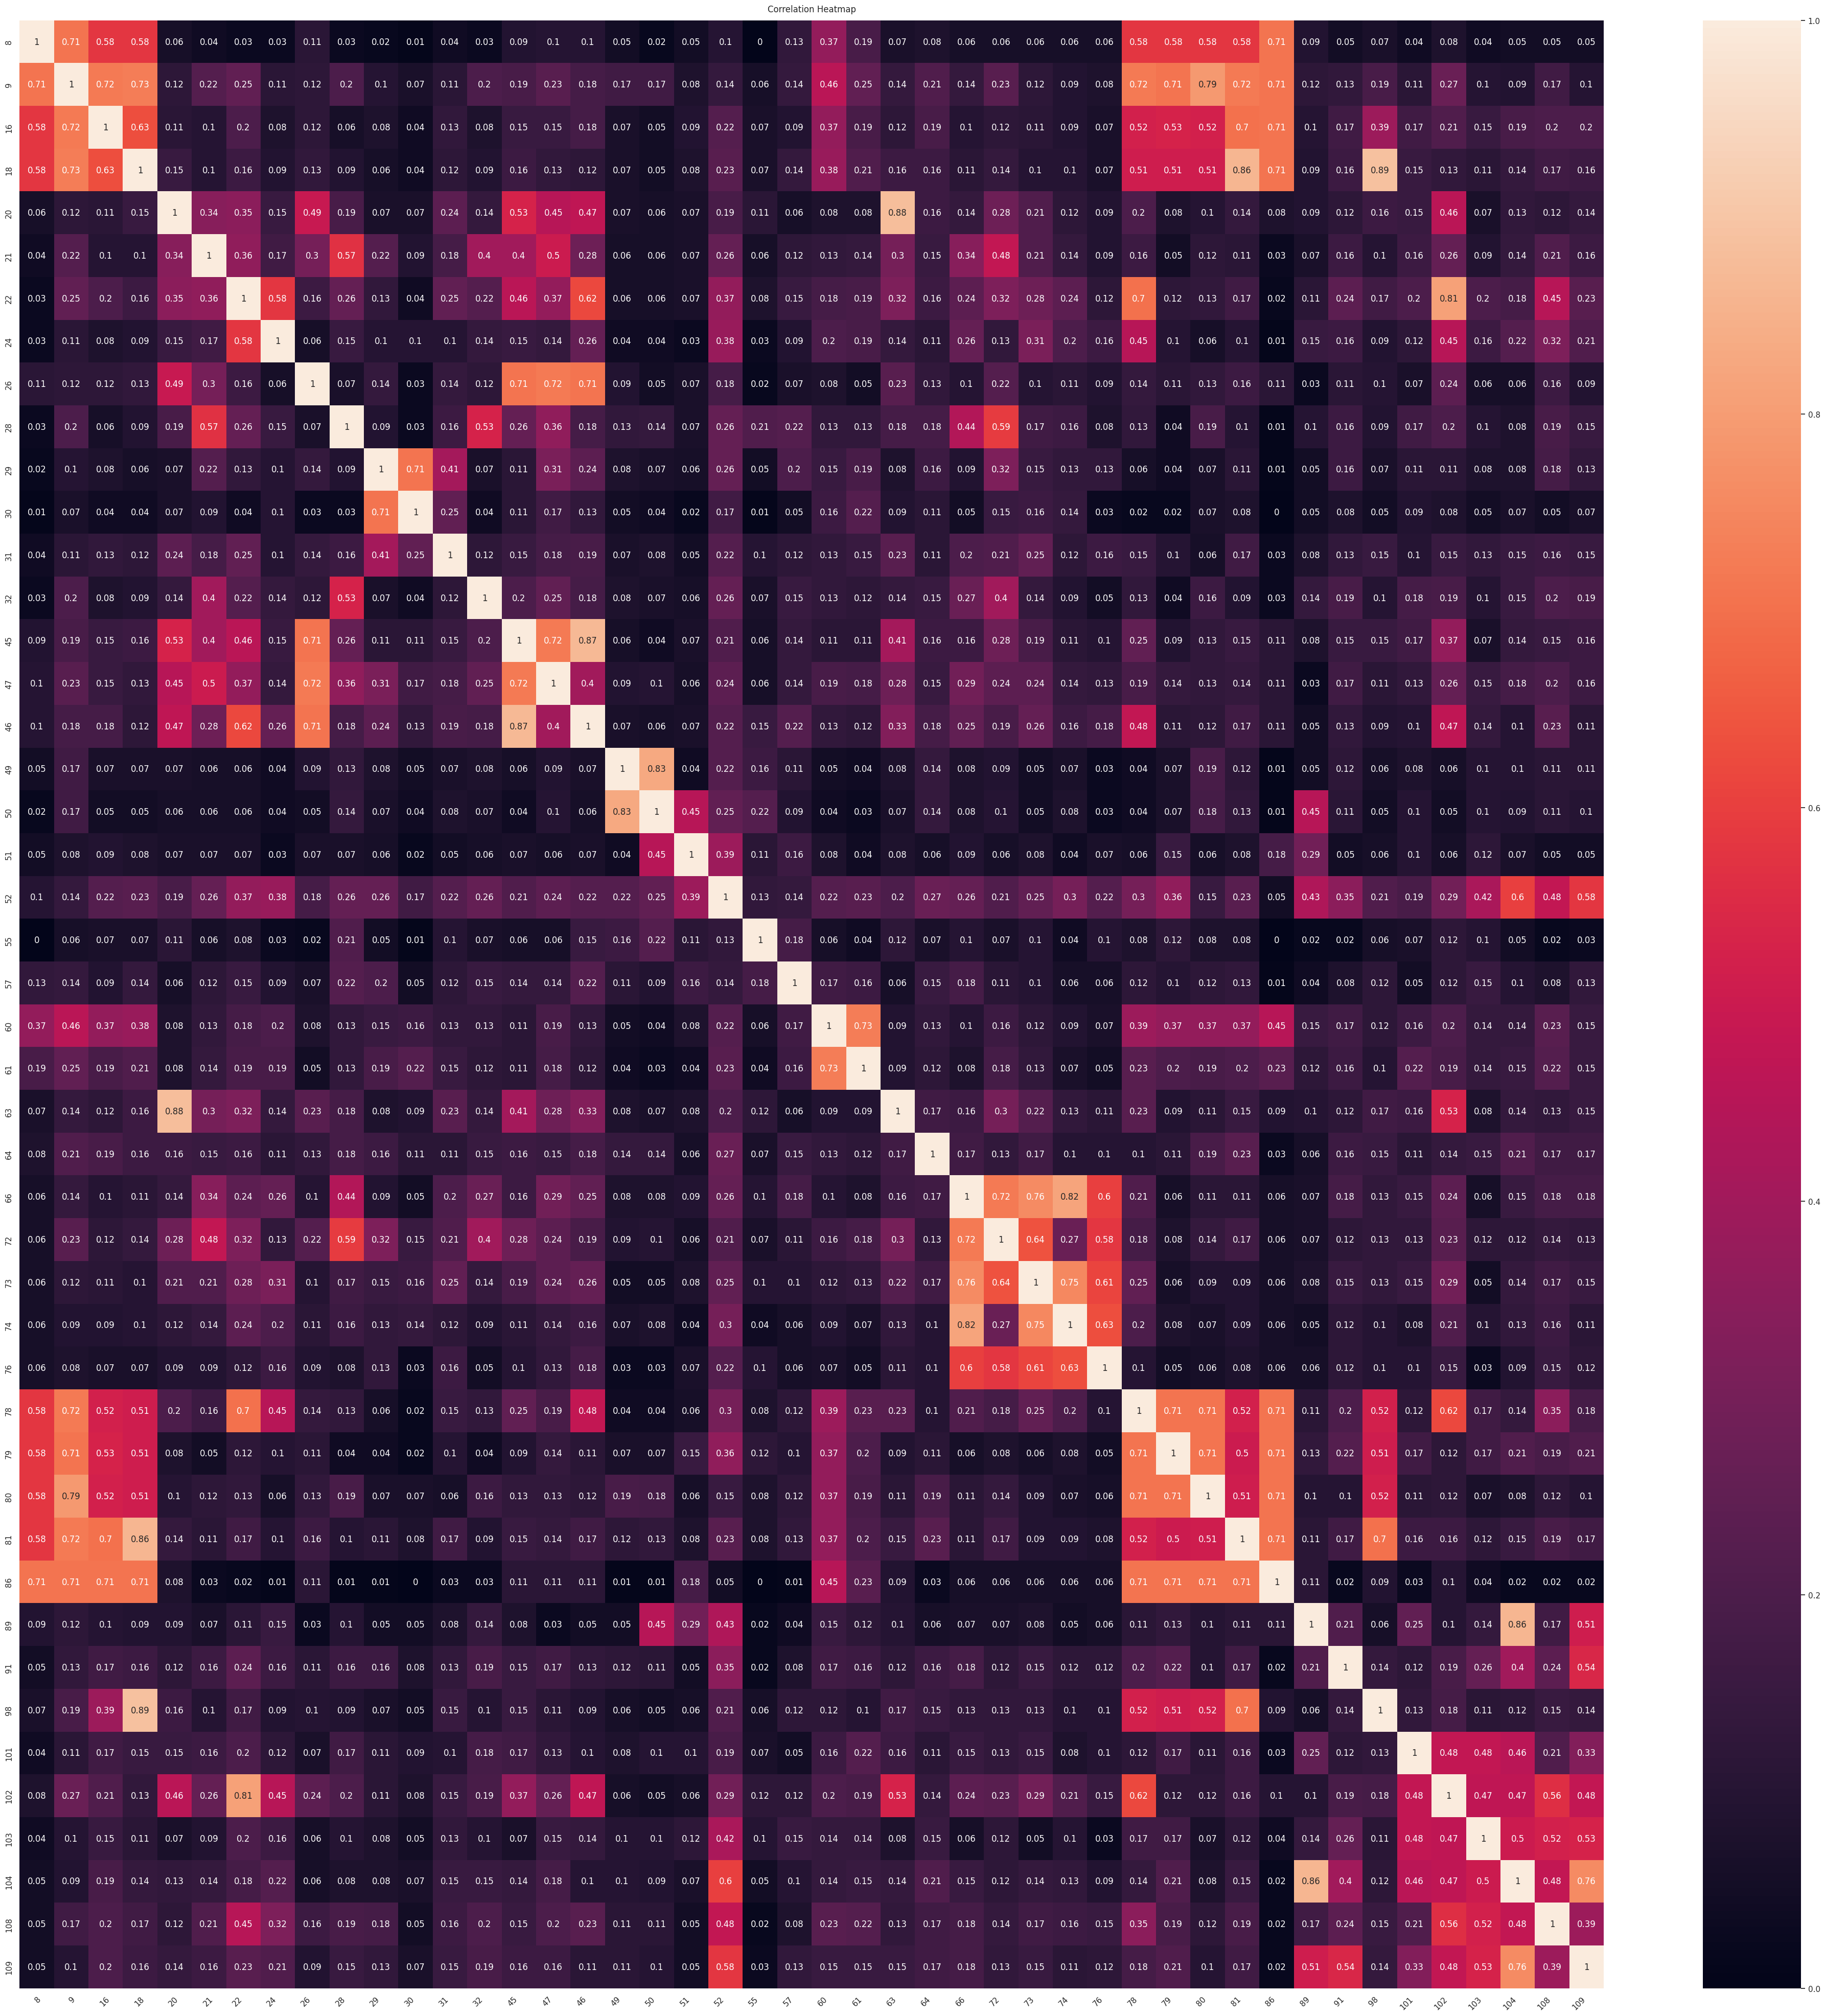

In [47]:
sb.set(rc={"figure.figsize": (50, 50)})
plot_corr_matrix(corr_matrix(parts_dataset[map(lambda x: features_name_to_code[str(x)], categorical_features_names)].drop(columns=categorical_features_codes_to_drop)))

# 2. Other features to drop detection

## 2.1. Features with too many missing values detection

In [48]:
# Here we drop the features that have less than 70% of assigned values over the dataset
other_columns_to_drop = set()
eff = parts_dataset.shape[0]
for col, count in parts_dataset.describe(include='all').loc['count',:].iteritems():
    if count/eff < 0.6:
        print(col, features_code_to_name[col], count/eff)
        other_columns_to_drop.add(col)

0 AverageInventory 0.45228072596784213
2 FullCounterfeitData|PartNumCounterfeitReportsCount 0.3564281278034642
23 EnvironmentalDto|ExemptionType 0.3040507901456076
58 SummaryData|AuthorizedDistributors 0.45228072596784213
70 ReachData|ReachDto|SubstanceLocation 0.11289766061693465
71 ReachData|ReachDto|SubstanceConcentration 0.10723897591608585
77 ReachData|ReachDto|NotificationComment 0.017804154302670624
87 RiskData|SEGrade 0.5983023945897453
88 RiskData|YeolComment 0.4742253812711338
93 PackageData|Feature>Product Diameter:Value 0.09067697191360155
96 PackageData|Feature>Terminal Pitch:Value 0.05479262990821889
112 PackageData|Feature>Product Weight:MinValue 0.24912014353736803
113 PackageData|Feature>Product Weight:MaxValue 0.24912014353736803


In [69]:
final_parts_dataset = parts_dataset.drop(columns=list(numerical_features_codes_to_drop.union(categorical_features_codes_to_drop).union(other_columns_to_drop)))
final_parts_dataset.index = final_parts_dataset['111']
final_parts_dataset = final_parts_dataset.drop(columns=['111'])

In [118]:
final_parts_dataset_to_save = final_parts_dataset.copy()
final_parts_dataset_to_save.rename(columns={x: features_code_to_name[x] for x in final_parts_dataset_to_save.columns}, inplace=True)
final_parts_dataset_to_save.index.name = features_code_to_name[final_parts_dataset_to_save.index.name]

In [120]:
final_parts_dataset_to_save.to_csv("../data/prepared_parts_dataset.csv")

In [128]:
set(date_features_names).intersection(final_parts_dataset_to_save.columns)

{'EnvironmentalDto|ExemptionExpirationDate',
 'LifeCycleData|LTBDate',
 'ReachData|ReachDto|SVHCDateOfInclusion',
 'ReachData|ReachDto|SVHCListVersion',
 'SummaryData|IntroductionDate',
 'SummaryData|LastCheckDate'}

In [125]:
len(categorical_features_names)

69